# Imports

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h2o
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
from sklego.preprocessing import RepeatingBasisFunction
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
from catboost import Pool


In [83]:
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

# EDA

## Domain knowledge


The group carried out research to obtain domain knowledge. The group used the weather parameter description provided in the Kaggle tournament (https://www.meteomatics.com/en/api/available-parameters/alphabetic-list/).

It was important to understand the dataset during feature engineering, understanding which features were most important and during pre/post-processing.

## Checking if data is intuitive

To get a good overview of the data we created plots for each feature. By doing this, the group identified several anomalies and inconsistencies among the features.

In [ ]:
#exploratory data analysis and vizualization 
columns = x_train_a.columns.to_list()

for el in columns: 
    # Plotting the pv_measurement over time for locations A, B, and C
    plt.figure(figsize=(20, 15))

    # Location A
    plt.subplot(3, 1, 1)
    plt.plot(x_train_a[el], label='Location A', color='blue')
    plt.title(f'Solar Energy Production {el} over Time for Location A')
    plt.xlabel('Time')
    plt.ylabel('Solar Energy Production')
    plt.legend()
    plt.grid(True)

    # Location B
    plt.subplot(3, 1, 2)
    plt.plot(x_train_b[el], label='Location B', color='green')
    plt.title(f'Solar Energy Production {el} over Time for Location B')
    plt.xlabel('Time')
    plt.ylabel('Solar Energy Production')
    plt.legend()
    plt.grid(True)

    # Location C
    plt.subplot(3, 1, 3)
    plt.plot(x_train_c[el], label='Location C', color='red')
    plt.title(f'Solar Energy Production {el} over Time for Location C')
    plt.xlabel('Time')
    plt.ylabel('Solar Energy Production')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()






### Constant values in PV-measurement and gaps

Observed recurring gaps for both zero and non-zero values, indicating faulty measurements. These were dealt with during pre-processing by dropping these rows.

### Different time stamps: Every 15 minutes and hourly

We observed that the datasets containing all the features (X_data) were aggregated to every 15 minutes, while the target values (PV-measurement) were aggregated every 1 hour. We dealt with this during pre-processing by aggregating from every 15 minutes to 1 hour by taking the mean values.

### NaN values in snow_density

Identified many NaN values in snow_density, so the group dropped the whole column.

### Observed/Estimated

The group looked at the transition between observed and estimated data. Realizing a large time gap between the two. The group decided not to adress this gap, other than flagging estimated and observed data. Which turned into an important cat_feature. 

## Understand how the data was generated

### Measurement errors observed

As previously mentioned, the group had to make assumptions about data inconsistencies. For example that large time gaps was because of faulty measurements, leading to the group dropping this data as it was noisy.

### Estimated inconsistencies

The group had a realistic approach to the estimated data. The fact that they are predictions from a meteorologist means that they are not accurate, and is a source of error. Differing from observed data that is historical data. It is also important to realize that observed data may not repeat itself in the future. That is why we avoided interpolation based on previous data.

## Explore individual features

As previously elaborated upon, the group explored individual features. Feature importance plots were also important to understand which features our models viewed as most important. This will be further discussed in the *Feature Importance* section.

This information was further used to choose features to drop i.e. snow_density, and features we could further feature engineer, which will be discussed further in the *Pre-processing* section.

## Explore pairs and groups of features

### Correlation matrices

The group created a correlation matrix for each location to aid in feature selection. Features with high correlation may be linearly dependent, meaning they often impact the dependent variable in a similar manner. Therefore, if two features have high correlation, it could be wise to remove one of them to reduce noise. However, the group decided not to drop such features, because we got good results with them included.

In [104]:
X_train_a.corr()

/var/folders/ln/psx1xlb54d58wpx85ns5z98h0000gn/T/ipykernel_23911/3385691667.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  X_train_a.corr()


,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,month,hour_sinus,hour_cosine,month_sinus,month_cosine
absolute_humidity_2m:gm3,1.000000,-0.811478,0.063329,0.366581,0.363520,0.025719,0.132184,0.974562,0.295128,0.301519,...,-0.157562,-0.136491,0.083607,-0.249636,0.006407,0.243944,-0.023352,-0.016956,-0.575392,-0.604049
air_density_2m:kgm3,-0.811478,1.000000,-0.129605,-0.474818,-0.464426,-0.106501,-0.065350,-0.844607,-0.403163,-0.416103,...,-0.006530,-0.036778,-0.008558,0.138559,-0.001818,-0.184682,0.059082,0.188816,0.457304,0.517394
ceiling_height_agl:m,0.063329,-0.129605,1.000000,0.075551,0.067538,0.713403,0.038641,0.050767,0.076778,0.082445,...,0.447609,-0.157503,-0.312184,0.013718,-0.003073,0.033466,-0.076837,-0.027829,-0.033149,-0.081657
clear_sky_energy_1h:J,0.366581,-0.474818,0.075551,1.000000,0.992517,0.055961,-0.073003,0.370135,0.913141,0.923154,...,0.081364,0.008613,0.073472,-0.341088,-0.005469,-0.055498,0.007556,-0.647880,-0.065372,-0.533711
clear_sky_rad:W,0.363520,-0.464426,0.067538,0.992517,1.000000,0.051751,-0.072347,0.367086,0.919161,0.915734,...,0.072125,-0.000983,0.068390,-0.326970,-0.006821,-0.055396,0.093228,-0.641274,-0.065134,-0.532381
cloud_base_agl:m,0.025719,-0.106501,0.713403,0.055961,0.051751,1.000000,0.040370,0.015117,0.029791,0.034260,...,0.454848,-0.197357,-0.377231,0.048622,0.002207,0.030059,-0.048105,-0.030812,-0.030270,-0.033866
dew_or_rime:idx,0.132184,-0.065350,0.038641,-0.073003,-0.072347,0.040370,1.000000,0.132673,-0.073721,-0.075342,...,-0.032023,-0.104564,-0.033058,0.003573,-0.001520,0.076893,-0.006171,0.121801,-0.127857,-0.031396
dew_point_2m:K,0.974562,-0.844607,0.050767,0.370135,0.367086,0.015117,0.132673,1.000000,0.302624,0.308913,...,-0.182619,-0.090641,0.124224,-0.235498,0.007905,0.259460,-0.023804,-0.025043,-0.572056,-0.598736
diffuse_rad:W,0.295128,-0.403163,0.076778,0.913141,0.919161,0.029791,-0.073721,0.302624,1.000000,0.988242,...,0.093951,-0.002243,0.067611,-0.299287,-0.005011,-0.076090,0.087996,-0.632012,-0.026097,-0.497522
diffuse_rad_1h:J,0.301519,-0.416103,0.082445,0.923154,0.915734,0.034260,-0.075342,0.308913,0.988242,1.000000,...,0.102392,0.005034,0.071322,-0.314160,-0.003235,-0.076611,0.004010,-0.640168,-0.026993,-0.503331


In [105]:
X_train_b.corr()

/var/folders/ln/psx1xlb54d58wpx85ns5z98h0000gn/T/ipykernel_23911/617364544.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  X_train_b.corr()


,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,month,hour_sinus,hour_cosine,month_sinus,month_cosine
absolute_humidity_2m:gm3,1.000000,-0.796029,0.048086,0.342766,0.340460,0.015741,0.101772,0.973628,0.264548,0.269238,...,-0.213330,-0.109173,0.097021,-0.213897,0.006504,0.298103,-0.017163,-0.010492,-0.549763,-0.543604
air_density_2m:kgm3,-0.796029,1.000000,-0.111037,-0.415328,-0.403598,-0.105465,-0.045774,-0.829165,-0.340809,-0.353807,...,0.061759,-0.075378,-0.013299,0.095243,-0.000171,-0.246749,0.071025,0.139618,0.445756,0.448014
ceiling_height_agl:m,0.048086,-0.111037,1.000000,0.105858,0.098738,0.722616,0.012937,0.044241,0.096076,0.101091,...,0.409106,-0.129262,-0.278569,0.017894,-0.002220,0.093367,-0.059997,-0.048531,-0.053750,-0.084471
clear_sky_energy_1h:J,0.342766,-0.415328,0.105858,1.000000,0.992521,0.121314,-0.055848,0.342814,0.910587,0.920642,...,0.025039,0.009732,0.052908,-0.330520,-0.006550,-0.033968,0.011234,-0.618284,-0.031699,-0.547849
clear_sky_rad:W,0.340460,-0.403598,0.098738,0.992521,1.000000,0.115547,-0.055231,0.340172,0.916634,0.913172,...,0.015870,-0.000693,0.048315,-0.317534,-0.008690,-0.033710,0.094784,-0.611987,-0.031823,-0.546091
cloud_base_agl:m,0.015741,-0.105465,0.722616,0.121314,0.115547,1.000000,0.007695,0.008649,0.087666,0.094179,...,0.435743,-0.163727,-0.327930,0.021920,-0.000964,0.044187,-0.049657,-0.060289,-0.006998,-0.083934
dew_or_rime:idx,0.101772,-0.045774,0.012937,-0.055848,-0.055231,0.007695,1.000000,0.097103,-0.056859,-0.058284,...,-0.043192,-0.091855,-0.022010,-0.000797,-0.001628,0.063563,-0.003475,0.083093,-0.085819,-0.012348
dew_point_2m:K,0.973628,-0.829165,0.044241,0.342814,0.340172,0.008649,0.097103,1.000000,0.270488,0.275489,...,-0.250474,-0.063773,0.139820,-0.196827,0.008306,0.324600,-0.020960,-0.018970,-0.548046,-0.528419
diffuse_rad:W,0.264548,-0.340809,0.096076,0.910587,0.916634,0.087666,-0.056859,0.270488,1.000000,0.988411,...,0.035927,0.005617,0.052987,-0.286201,-0.006313,-0.056200,0.090414,-0.612552,0.007152,-0.507162
diffuse_rad_1h:J,0.269238,-0.353807,0.101091,0.920642,0.913172,0.094179,-0.058284,0.275489,0.988411,1.000000,...,0.043346,0.014087,0.056488,-0.300543,-0.003660,-0.057436,0.007218,-0.620201,0.008105,-0.513399


In [106]:
X_train_c.corr()

/var/folders/ln/psx1xlb54d58wpx85ns5z98h0000gn/T/ipykernel_23911/3725641665.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  X_train_c.corr()


,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,month,hour_sinus,hour_cosine,month_sinus,month_cosine
absolute_humidity_2m:gm3,1.000000,-0.768513,0.078560,0.302728,0.300231,-0.012464,0.255957,0.977885,0.227046,0.232293,...,-0.214544,-0.143755,0.056014,-0.246249,0.010492,0.240783,-0.024955,-0.023093,-0.526380,-0.487437
air_density_2m:kgm3,-0.768513,1.000000,-0.137715,-0.459637,-0.447946,-0.062564,-0.210685,-0.792147,-0.382711,-0.395920,...,0.007713,-0.086951,0.038658,0.090389,0.059646,-0.148071,0.067957,0.222807,0.393475,0.427776
ceiling_height_agl:m,0.078560,-0.137715,1.000000,0.077644,0.071282,0.719340,-0.025206,0.060039,0.081147,0.084168,...,0.457253,-0.175598,-0.344758,0.056032,-0.037729,0.030124,-0.056089,0.005706,-0.027059,-0.141334
clear_sky_energy_1h:J,0.302728,-0.459637,0.077644,1.000000,0.991993,0.024371,-0.021161,0.310793,0.911910,0.921019,...,0.066538,0.023574,0.065170,-0.388706,0.037654,-0.117394,0.011991,-0.652983,0.030449,-0.517636
clear_sky_rad:W,0.300231,-0.447946,0.071282,0.991993,1.000000,0.022211,-0.020526,0.307900,0.916906,0.911756,...,0.058922,0.013040,0.061027,-0.371644,0.034487,-0.116707,0.100744,-0.645391,0.029882,-0.516748
cloud_base_agl:m,-0.012464,-0.062564,0.719340,0.024371,0.022211,1.000000,-0.050026,-0.031486,0.008792,0.010999,...,0.446693,-0.203623,-0.378255,0.112089,-0.055092,0.007187,-0.035661,0.002895,-0.001915,-0.037910
dew_or_rime:idx,0.255957,-0.210685,-0.025206,-0.021161,-0.020526,-0.050026,1.000000,0.275979,-0.020510,-0.021490,...,-0.118305,-0.033721,0.013149,-0.023255,0.000440,0.108169,0.001340,0.051051,-0.199167,-0.061445
dew_point_2m:K,0.977885,-0.792147,0.060039,0.310793,0.307900,-0.031486,0.275979,1.000000,0.236923,0.242510,...,-0.244830,-0.098626,0.083329,-0.228859,0.012649,0.258205,-0.028784,-0.037812,-0.524775,-0.480544
diffuse_rad:W,0.227046,-0.382711,0.081147,0.911910,0.916906,0.008792,-0.020510,0.236923,1.000000,0.988042,...,0.078966,0.015648,0.063589,-0.340563,0.041651,-0.132418,0.088375,-0.636133,0.062117,-0.478823
diffuse_rad_1h:J,0.232293,-0.395920,0.084168,0.921019,0.911756,0.010999,-0.021490,0.242510,0.988042,1.000000,...,0.084603,0.022728,0.066543,-0.358827,0.044440,-0.134410,0.001783,-0.644323,0.063459,-0.484011


### Wind features

We realized that the dataset contained several wind features. Including different wind vectors and one absolute value. The first though was to only include the absolute value, and drop the vectors. But we did not gain any better results by doing this. So, we decided not to go further with this.

## Clean up features

### NaN values

Removing columns where there are a substantial amount of NaN values and constant values as previously elaborated upon.

# Pre-processing

## Pre-processing X

**Data aggregation**: Initially, it groups data by hour (`'1H'`) and calculates the mean for each group. This step is important to solve the problem regarding different data aggregation identified during the EDA.

**Handling missing values**: Removes rows where all elements are NaN, to remove time gaps.

**Feature engineering**: Extracts time-related features from the index, such as `hour`, `week`, and a combined `week_hour` feature (used for avg_measurement, which will be discussed later). Also adds `month` as a feature. This is later used for encoding.

**Cyclical feature encoding**: Transforms `hour` and `month` into sinus and cosinus components to capture the cyclical nature of these time features.

**Feature removal**: Drops several columns including `snow_density:kgm3`, `month`, `hour`, `week`, and `week_hour`. As mentioned, we investigated individual features during EDA. And dropped snow_density because of many NaN values. After the cyclical encoding, `month` and `hour` is also removed. We tried using `week_hour` and `week` during training, but worsened our results.

**Categorical encoding for elevation**: Maps elevation values to categorical labels (`A`, `B`, `C`) and then drops the original `elevation:m` column.

In [84]:
def preprocessing_X(df):
    data = df.copy()
    if 'date_calc' in data.columns:
        data.drop('date_calc', axis=1, inplace=True)

    if 'date_forecast' in data.columns:
        data.set_index('date_forecast', inplace=True)

    
    data = data.groupby(pd.Grouper(freq='1H')).mean()
    #data = data.groupby(pd.Grouper(freq='1H')).agg(custom_agg)
    
    
    data.dropna(how='all', inplace=True)
    
    data['hour'] = data.index.hour
    data['week'] = pd.to_numeric(data.index.isocalendar().week)
    data['week_hour'] = data['week'] * 100 + data['hour']
    data['month'] = data.index.month


    #TODO: prøv annen encoding her
    data['hour_sinus'] = np.sin(2*np.pi*data['hour']/ 23)
    data['hour_cosine'] = np.cos(2*np.pi*data['hour'] / 23)

    data['month_sinus'] = np.sin(2*np.pi*data['month'] / 12)
    data['month_cosine'] = np.cos(2*np.pi*data['month'] / 12)

    

    data.drop(columns=['snow_density:kgm3', 'hour', 'month', 'week','week_hour'], inplace=True)
    
    data.rename_axis('time', inplace=True)

    mapping = elevation_mapping = {
            6.0 : 'A',
            7.0 : 'B',
            24.0 : 'C'
        }
    
    data['location'] = data['elevation:m'].map(mapping)
    data['location'] = data['location'].astype(str)
    data.drop(columns=['elevation:m'], inplace=True)
    
    return data

## Custom_agg attempt

The aim with this dictionary was to adapt which aggregation method to use for each feature. The reason why we did this was because of the different nature of the features. We did not manage to implement this. So, we ended up just doing mean for each feature.

In [107]:
custom_agg = {
    'absolute_humidity_2m:gm3': 'mean',
    'air_density_2m:kgm3': 'mean',
    'ceiling_height_agl:m': 'mean',
    'clear_sky_energy_1h:J': 'sum',
    'clear_sky_rad:W': 'mean',
    'cloud_base_agl:m': 'mean',
    'dew_or_rime:idx': 'mean',
    'dew_point_2m:K': 'mean',
    'diffuse_rad:W': 'mean',
    'diffuse_rad_1h:J': 'sum',
    'direct_rad:W': 'mean',
    'direct_rad_1h:J': 'sum',
    'effective_cloud_cover:p': 'mean',
    'elevation:m': 'mean',
    'fresh_snow_12h:cm': 'sum',
    'fresh_snow_1h:cm': 'sum',
    'fresh_snow_24h:cm': 'sum',
    'fresh_snow_3h:cm': 'sum',
    'fresh_snow_6h:cm': 'sum',
    'is_day:idx': 'mean',  
    'is_in_shadow:idx': 'mean',  
    'msl_pressure:hPa': 'mean',
    'precip_5min:mm': 'sum',
    'precip_type_5min:idx': 'mean',  
    'pressure_100m:hPa': 'mean',
    'pressure_50m:hPa': 'mean',
    'prob_rime:p': 'mean',
    'rain_water:kgm2': 'sum',
    'relative_humidity_1000hPa:p': 'mean',
    'sfc_pressure:hPa': 'mean',
    'snow_density:kgm3': 'mean',
    'snow_depth:cm': 'mean',
    'snow_drift:idx': 'mean',
    'snow_melt_10min:mm': 'sum',
    'snow_water:kgm2': 'sum',
    'sun_azimuth:d': 'mean',
    'sun_elevation:d': 'mean',
    'super_cooled_liquid_water:kgm2': 'sum',
    't_1000hPa:K': 'mean',
    'total_cloud_cover:p': 'mean',
    'visibility:m': 'mean',
    'wind_speed_10m:ms': 'mean',
    'wind_speed_u_10m:ms': 'mean',
    'wind_speed_v_10m:ms': 'mean',
    'wind_speed_w_1000hPa:ms': 'mean'
}

## Pre-processing Y

**Filtering consecutive values**:
  - The first function is only used on location B and C, as the data from location A is deemed to be of high quality from our EDA.
  - A mask is created to identify sequences of 3 or more consecutive rows where `pv_measurement` is the same and non-zero. Done to remove erroneous constant data, assumed to be faulty measurements.
  - Another mask is created to identify sequences of 24 or more consecutive zero values in `pv_measurement`. Filters out these long sequences of zero values. As mentioned in the EDA section, there may be periods of inactivity or downtime that are not relevant for the analysis.

**Handling missing values**: Drops any rows with NaN values.


In [85]:
def remove_constants_Y(df):
    data = df.copy()

    # Create a mask to identify sequences of 3 or more consecutive rows with the same 'pv_measurement' (non-zero)
    consecutive_mask = (data['pv_measurement'] == data['pv_measurement'].shift(1)) & (data['pv_measurement'] != 0)
    consecutive_count = consecutive_mask.groupby((~consecutive_mask).cumsum()).cumsum()
    mask_consecutive = (consecutive_count <= 3) | (~consecutive_mask)

    #create a mask to identify sequences of 24 or more consecutive 0-valued pv-measurement
    consecutive_mask_0 = (data['pv_measurement'] == data['pv_measurement'].shift(1)) & (data['pv_measurement'] == 0)
    consecutive_count_0 = consecutive_mask_0.groupby((~consecutive_mask_0).cumsum()).cumsum()
    mask_consecutive_0 = (consecutive_count_0 <= 24) | (~consecutive_mask_0)

    combined_mask = mask_consecutive & mask_consecutive_0

    filtered_data = data[combined_mask]

    return filtered_data


def preprocessing_Y(df):
    data = df.copy()
    if 'time' in data.columns:
        data.set_index('time', inplace=True)
    data.dropna(inplace=True)
    
    return data

## Feature engineering

The following are examples of feature extractions, and we excluded snow_density as previously mentioned.

**Average measurements**:
Added the hourly average measurements corrosponding to the week number of all PV-measurements. We thought this might be a good starting point for the model to predict the PV-measurement.  

    Example: For 0800 in week 42, we calculate the average of this hour for this week from all other years and add this as a new feature.

However, this did not give us great results, so we decided not to go further with it. 

**Estimated/Observed flag**:
Added a flag for estimated and observed data to let the models learn the difference.

**Radial basis function**:
An attempt to implement a radial basis function. The idea was to encode the time stamps to exploit the continuity of our time features. We did not manage to implement it, so we stuck with cosine/sine encoding.

In [86]:
def generating_avgmeas(df): 
    data = df.copy()
    for location in data['location'].unique():
        # Filter the DataFrame for the current loc_flag value
        filtered_df = data[data['location'] == location]
        
        # Group the filtered DataFrame by 'month' and calculate the mean 'pv_measurement'
        avg_measurement_by_month = filtered_df.groupby('week_hour')['pv_measurement'].mean()
        
        # Convert the result to a dictionary
        avg_measurement_dict = avg_measurement_by_month.to_dict()
        
        # Assign the result to the appropriate dictionary based on loc_flag value
        if location == 'A':
            average_measurement_a = avg_measurement_dict
        elif location == 'B':
            average_measurement_b = avg_measurement_dict
        elif location == 'C':
            average_measurement_c = avg_measurement_dict
    return average_measurement_a, average_measurement_b, average_measurement_c

def add_avgmeas(average_measurement_a, average_measurement_b, average_measurement_c, df):
    data = df.copy()
    data['average_measurement'] = data.apply(lambda row: average_measurement_a[row['week_hour']]
                                            if row['location'] == 'A'
                                            else (average_measurement_b[row['week_hour']]
                                                if row['location'] == 'B'
                                                else average_measurement_c[row['week_hour']]), axis=1)
    
    data.drop(columns=['week_hour'], inplace=True)
    return data

def add_estimated_flag(df, estimated):
    data = df.copy()

    data['estimated'] = 'E' if estimated else 'O'

    return data

def rbf_function(df,column_name,N_PERIODS):
    rbf = RepeatingBasisFunction(n_periods=N_PERIODS,
                            remainder='passthrough',
                            column=column_name,
                            input_range=(df[column_name].min() ,df[column_name].max()))
    rbf.fit(df)
    data_period = pd.DataFrame(rbf.transform(df), columns=df.columns)
    return data_periodz

### Handling datasets for multiple locations

- **Feature scaling**: Applies MinMaxScaler to the `pv_measurement` feature in each dataset. This normalization step scales the data to a value between 0 and 1.

- For each of the datasets (A, B, C), the following steps are executed:
  - **Data preprocessing**: Applies the `preprocessing_X` function to both observed and estimated data.
  - **Flag addition**: Adds a flag to differentiate between observed and estimated data using the `add_estimated_flag` function.
  - **Concatenating observed and estimated** 

- **Merging features and labels**: Each feature set (`x_train_a`, `x_train_b`, `x_train_c`) is merged with its respective labels, processed by `preprocessing_Y` (and `remove_constants_Y` where applicable), based on the 'time' column.
- **Concatenating datasets**: Concatenates the processed feature and label sets for all three datasets into `x_train` and `transformed_x_train`.
- **Train-validation split**: Splits both the original and transformed datasets into training and validation sets using `train_test_split`.


**Separates dataset by location**
- Separates the training and validation datasets into sub-datasets based on the 'location' feature, creating separate datasets for locations A, B, and C.


**Test data preparation**
- Prepares test data (`x_test_a`, `x_test_b`, `x_test_c`) using the `preprocessing_X` function and adds an estimated flag. 
- Concatenates these datasets into a single `x_test` dataset.


In [96]:
transformed_train_a = train_a.copy()
transformed_train_b = train_b.copy()
transformed_train_c = train_c.copy()

scaler_a = MinMaxScaler()
scaler_b = MinMaxScaler()
scaler_c = MinMaxScaler()

transformed_train_a['pv_measurement'] = scaler_a.fit_transform(train_a[['pv_measurement']])
transformed_train_b['pv_measurement'] = scaler_b.fit_transform(train_b[['pv_measurement']])
transformed_train_c['pv_measurement'] = scaler_c.fit_transform(train_c[['pv_measurement']])

#combining observed and estimated data
observed_a = preprocessing_X(X_train_observed_a)
observed_a = add_estimated_flag(observed_a, False)

estimated_a = preprocessing_X(X_train_estimated_a)
estimated_a = add_estimated_flag(estimated_a, True)


x_train_a = pd.concat([observed_a, estimated_a], axis=0)
y_train_a = preprocessing_Y(train_a)
m_train_a = x_train_a.merge(y_train_a, how='inner', on='time')

transformed_y_train_a = preprocessing_Y(transformed_train_a)
transformed_m_train_a = x_train_a.merge(transformed_y_train_a, how='inner', on='time')

observed_b = preprocessing_X(X_train_observed_b)
observed_b = add_estimated_flag(observed_b, False)

estimated_b = preprocessing_X(X_train_estimated_b)
estimated_b = add_estimated_flag(estimated_b, True)

x_train_b = pd.concat([observed_b, estimated_b], axis=0)
y_train_b = preprocessing_Y(train_b)
y_train_b = remove_constants_Y(y_train_b)
m_train_b = x_train_b.merge(y_train_b, how='inner', on='time')

transformed_y_train_b = preprocessing_Y(transformed_train_b)
transformed_y_train_b = remove_constants_Y(transformed_y_train_b)
transformed_m_train_b = x_train_b.merge(transformed_y_train_b, how='inner', on='time')

observed_c = preprocessing_X(X_train_observed_c)
observed_c = add_estimated_flag(observed_c, False)

estimated_c = preprocessing_X(X_train_estimated_c)
estimated_c = add_estimated_flag(estimated_c, True)


x_train_c = pd.concat([observed_c, estimated_c], axis=0)
y_train_c = preprocessing_Y(train_c)
y_train_c = remove_constants_Y(y_train_c)
m_train_c = x_train_c.merge(y_train_c, how='inner', on='time')

transformed_y_train_c = preprocessing_Y(transformed_train_c)
transformed_y_train_c = remove_constants_Y(transformed_y_train_c)
transformed_m_train_c = x_train_c.merge(transformed_y_train_c, how='inner', on='time')

x_train = pd.concat([m_train_a, m_train_b, m_train_c], axis=0, ignore_index=True)

transformed_x_train = pd.concat([transformed_m_train_a, transformed_m_train_b, transformed_m_train_c], axis=0, ignore_index=True)


y_train = x_train['pv_measurement']
transformed_y_train = transformed_x_train['pv_measurement']

x_train = x_train.drop(columns=['pv_measurement'], axis=1)
transformed_x_train = transformed_x_train.drop(columns=['pv_measurement'], axis=1)

X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=10)
transformed_X_train, transformed_X_val, transformed_Y_train, transformed_Y_val = train_test_split(transformed_x_train, transformed_y_train, test_size=0.2, shuffle=True, random_state=10)

X_train_a = X_train[X_train['location'] == 'A']
X_train_b = X_train[X_train['location'] == 'B']
X_train_c = X_train[X_train['location'] == 'C']

transformed_X_train_a = transformed_X_train[transformed_X_train['location'] == 'A']
transformed_X_train_b = transformed_X_train[transformed_X_train['location'] == 'B']
transformed_X_train_c = transformed_X_train[transformed_X_train['location'] == 'C']

Y_train_a = Y_train[X_train['location'] == 'A']
Y_train_b = Y_train[X_train['location'] == 'B']
Y_train_c = Y_train[X_train['location'] == 'C']

transformed_Y_train_a = transformed_Y_train[transformed_X_train['location'] == 'A']
transformed_Y_train_b = transformed_Y_train[transformed_X_train['location'] == 'B']
transformed_Y_train_c = transformed_Y_train[transformed_X_train['location'] == 'C']

X_val_a = X_val[X_val['location'] == 'A']
X_val_b = X_val[X_val['location'] == 'B']
X_val_c = X_val[X_val['location'] == 'C']

transformed_X_val_a = transformed_X_val[transformed_X_val['location'] == 'A']
transformed_X_val_b = transformed_X_val[transformed_X_val['location'] == 'B']
transformed_X_val_c = transformed_X_val[transformed_X_val['location'] == 'C']

Y_val_a = Y_val[X_val['location'] == 'A']
Y_val_b = Y_val[X_val['location'] == 'B']
Y_val_c = Y_val[X_val['location'] == 'C']

transformed_Y_val_a = transformed_Y_val[transformed_X_val['location'] == 'A']
transformed_Y_val_b = transformed_Y_val[transformed_X_val['location'] == 'B']
transformed_Y_val_c = transformed_Y_val[transformed_X_val['location'] == 'C']


x_test_a = preprocessing_X(X_test_estimated_a)
x_test_a = add_estimated_flag(x_test_a, True)

x_test_b = preprocessing_X(X_test_estimated_b)
x_test_b = add_estimated_flag(x_test_b, True)

x_test_c = preprocessing_X(X_test_estimated_c)
x_test_c = add_estimated_flag(x_test_c, True)


x_test = pd.concat([x_test_a, x_test_b, x_test_c], axis=0, ignore_index=True)

# Catboost

This is one of the models we decieded to proceed with, and is used in `1_short_notebook.ipynb`

In [112]:
params = {
    'depth' : 9,
    'iterations' : 1000,
    'loss_function' : 'MAE'
}

def catboost(X_train, Y_train, X_val, Y_val):
    # Instantiate the CatBoostRegressor with the predefined parameters
    model = CatBoostRegressor(**params)

    # Creating training
    train_pool = Pool(data=X_train, label=Y_train, cat_features=['location', 'estimated'])

    # Creating validation pool with categorical features specified
    eval_pool = Pool(data=X_val, label=Y_val, cat_features=['location', 'estimated'])

    # Train the model with the training pool and validate with the evaluation pool
    model.fit(train_pool, use_best_model=True, eval_set=eval_pool)
    
    return model 

# Function to train the model and predict, handling both single and multiple datasets
def train_predict(single=False):
    if not single:
        # Train model on a single dataset
        model = catboost(X_train, Y_train, X_val, Y_val)
        
        # Predict using the trained model and create a DataFrame with predictions
        predictions = pd.DataFrame(model.predict(x_test), columns=['prediction'])

        # Set 'id' as the index name of the DataFrame
        predictions.index.name = 'id'

        # Return the predictions and the trained model
        return predictions, model
    else:
        # Process for multiple datasets A, B, C follows the same logic as above
        model_a = catboost(X_train_a, Y_train_a, X_val_a, Y_val_a)
        predict_a = model_a.predict(x_test_a)
        predictions_a = pd.DataFrame(predict_a, columns=['prediction'])

        model_b = catboost(X_train_b, Y_train_b, X_val_b, Y_val_b)
        predict_b = model_b.predict(x_test_b)
        predictions_b = pd.DataFrame(predict_b, columns=['prediction'])
        
        model_c = catboost(X_train_c, Y_train_c, X_val_c, Y_val_c)
        predict_c = model_c.predict(x_test_c)
        predictions_c = pd.DataFrame(predict_c, columns=['prediction'])

        # Combine predictions from all datasets into a single DataFrame
        predictions = pd.concat([predictions_a, predictions_b, predictions_c], axis=0, ignore_index=True)

        predictions.index.name = 'id'

        return predictions, model_a, model_b, model_c

# Function similar to train_predict but uses transformed datasets
def transformed_train_predict(single=False):
    if not single:
        model = catboost(transformed_X_train, transformed_Y_train, transformed_X_val, transformed_Y_val)
        
        predictions = pd.DataFrame(model.predict(x_test), columns=['prediction'])

        predictions.index.name = 'id'

        return predictions, model
    else:
        # For each dataset (A, B, C), the predictions are scaled back after transformation
        model_a = catboost(transformed_X_train_a, transformed_Y_train_a, transformed_X_val_a, transformed_Y_val_a)
        predict_a = model_a.predict(x_test_a)
        predictions_a = pd.DataFrame(predict_a, columns=['prediction'])
        predictions_a.loc[:, 'prediction'] = scaler_a.inverse_transform(predictions_a['prediction'].values.reshape(-1, 1))
        
        model_b = catboost(transformed_X_train_b, transformed_Y_train_b, transformed_X_val_b, transformed_Y_val_b)
        predict_b = model_b.predict(x_test_b)
        predictions_b = pd.DataFrame(predict_b, columns=['prediction'])
        predictions_b.loc[:, 'prediction'] = scaler_b.inverse_transform(predictions_b['prediction'].values.reshape(-1, 1))
        
        model_c = catboost(transformed_X_train_c, transformed_Y_train_c, transformed_X_val_c, transformed_Y_val_c)
        predict_c = model_c.predict(x_test_c)
        predictions_c = pd.DataFrame(predict_c, columns=['prediction'])
        predictions_c.loc[:, 'prediction'] = scaler_c.inverse_transform(predictions_c['prediction'].values.reshape(-1, 1))

        # Combine and return predictions, inverse transformed to their original scale
        predictions = pd.concat([predictions_a, predictions_b, predictions_c], axis=0, ignore_index=True)

        predictions.index.name = 'id'
        
        return predictions, model_a, model_b, model_c


In [110]:
predictions, model_a, model_b, model_c = train_predict(single=True)

0:	learn: 613.6949583	test: 637.9119655	best: 637.9119655 (0)	total: 26.7ms	remaining: 26.7s
1:	learn: 600.4565139	test: 624.2826860	best: 624.2826860 (1)	total: 44.9ms	remaining: 22.4s
2:	learn: 585.9393093	test: 609.5256209	best: 609.5256209 (2)	total: 56.8ms	remaining: 18.9s
3:	learn: 571.6477337	test: 594.6777773	best: 594.6777773 (3)	total: 68.5ms	remaining: 17.1s
4:	learn: 559.1658257	test: 581.6975029	best: 581.6975029 (4)	total: 79.8ms	remaining: 15.9s
5:	learn: 546.7733121	test: 568.9330745	best: 568.9330745 (5)	total: 89.9ms	remaining: 14.9s
6:	learn: 535.0648659	test: 556.8117470	best: 556.8117470 (6)	total: 99.9ms	remaining: 14.2s
7:	learn: 524.2011484	test: 545.4672836	best: 545.4672836 (7)	total: 110ms	remaining: 13.6s
8:	learn: 514.3862996	test: 535.1005243	best: 535.1005243 (8)	total: 120ms	remaining: 13.2s
9:	learn: 502.8756839	test: 523.1327337	best: 523.1327337 (9)	total: 130ms	remaining: 12.9s
10:	learn: 492.0372048	test: 511.9116525	best: 511.9116525 (10)	total: 14

In [111]:
transformed_catboost_predictions, transformed_model_a, transformed_model_b, transformed_model_c  = transformed_train_predict(single=True)

0:	learn: 0.1070372	test: 0.1112610	best: 0.1112610 (0)	total: 20.5ms	remaining: 20.5s
1:	learn: 0.1047283	test: 0.1088839	best: 0.1088839 (1)	total: 35.4ms	remaining: 17.6s
2:	learn: 0.1021962	test: 0.1063100	best: 0.1063100 (2)	total: 46.3ms	remaining: 15.4s
3:	learn: 0.0997036	test: 0.1037204	best: 0.1037204 (3)	total: 58.4ms	remaining: 14.5s
4:	learn: 0.0975266	test: 0.1014564	best: 0.1014564 (4)	total: 71.3ms	remaining: 14.2s
5:	learn: 0.0953651	test: 0.0992301	best: 0.0992301 (5)	total: 81.7ms	remaining: 13.5s
6:	learn: 0.0933230	test: 0.0971160	best: 0.0971160 (6)	total: 93.6ms	remaining: 13.3s
7:	learn: 0.0914282	test: 0.0951373	best: 0.0951373 (7)	total: 105ms	remaining: 13s
8:	learn: 0.0897164	test: 0.0933292	best: 0.0933292 (8)	total: 118ms	remaining: 12.9s
9:	learn: 0.0877087	test: 0.0912419	best: 0.0912419 (9)	total: 128ms	remaining: 12.7s
10:	learn: 0.0858184	test: 0.0892848	best: 0.0892848 (10)	total: 140ms	remaining: 12.6s
11:	learn: 0.0841249	test: 0.0875320	best: 0.08

# XGBoost

Tried XGBoost, but got better results with Catboost, so we decided to go with Catboost.

In [ ]:
from xgboost import XGBRegressor

def xgboost(X_train, Y_train, X_val, Y_val):

    xgb_mapping = elevation_mapping = {
                'A': -1,
                'B': 0,
                'C': 1
            }

    X_train_xgb = X_train.copy()
    X_train_xgb['location'] = X_train_xgb['location'].map(xgb_mapping) 

    X_val_xgb = X_val.copy()
    X_val_xgb['location'] = X_val_xgb['location'].map(xgb_mapping)

    #Sinan added this to fix for test also
    x_test_a['location'] = x_test_a['location'].map(xgb_mapping)
    x_test_b['location'] = x_test_b['location'].map(xgb_mapping)
    x_test_c['location'] = x_test_c['location'].map(xgb_mapping)

    xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.125, n_jobs=3,eval_metric='mae')

    eval_set = [(X_val_xgb, Y_val)]

    xgb_model.fit(X_train_xgb, Y_train, eval_set=eval_set,early_stopping_rounds=500)
    return xgb_model

def xgboost_train_predict(single=False):
    lenlist = []
    if not single:

        xgbmodel = xgboost(X_train, Y_train, X_val, Y_val)
        
        predictions = pd.DataFrame(xgbmodel.predict(x_test), columns=['prediction'])

        predictions.index.name = 'id'

        return predictions, xgbmodel

    else:
        model_a = xgboost(X_train_a, Y_train_a, X_val_a, Y_val_a)
        predict_a = model_a.predict(x_test_a)
        predictions_a = pd.DataFrame(predict_a, columns=['prediction'])
        
        lenlist.append(len(predictions_a))

        model_b = xgboost(X_train_b, Y_train_b, X_val_b, Y_val_b)
        predict_b = model_b.predict(x_test_b)
        predictions_b = pd.DataFrame(predict_b, columns=['prediction'])

        lenlist.append(len(predictions_b))
        
        model_c = xgboost(X_train_c, Y_train_c, X_val_c, Y_val_c)
        predict_c = model_c.predict(x_test_c)
        predictions_c = pd.DataFrame(predict_c, columns=['prediction'])

        lenlist.append(len(predictions_c))

        predictions = pd.concat([predictions_a, predictions_b, predictions_c], axis=0, ignore_index=True)

        lenlist.append(len(predictions))

        predictions.index.name = 'id'

        return predictions, model_a, model_b, model_c, lenlist

In [ ]:
predictions, model_a, model_b, model_c, lenlist = xgboost_train_predict(single=True)
print(f'A:{model_a.best_score}')
print(f'B:{model_b.best_score}')
print(f'C:{model_c.best_score}')
print(lenlist)

# H2O AutoML

Started with AutoML to get some predictions up quickly. Met a plateau because it was difficult to understand what H2O does for pre-processing, feature engineering and model selection. So, we decided to explore other frameworks where we were more in control of the code.

In [ ]:
def train(train_df, val_df, type):

    h2o.init()
    train = h2o.H2OFrame(train_df)
    train.describe()

    val = h2o.H2OFrame(val_df)

    x = train.columns
    y = 'pv_measurement'
    x.remove(y)

    # import autoML from H2O
    
    # callh20automl  function
    aml = H2OAutoML(max_runtime_secs = 120,
                    sort_metric='MAE',
                    
    )
    # train model and record time % time
    aml.train(x = x, y = y, training_frame = train, validation_frame=val)

    # Obtain the leader model
    best_model = aml.leader

    # Save the leader model
    model_path = h2o.save_model(model=best_model, path="/tmp/mymodel", force=True)

    # Load the saved model
    loaded_model = h2o.load_model(model_path)

    # Download the model to local machine
    my_local_model = h2o.download_model(best_model, path=f"./models/{type.upper()}")

    h2o.cluster().shutdown()

    return my_local_model

 

In [ ]:
model_A = train(m_train_a, m_val_a, 'a')

In [ ]:
model_B = train(m_train_b, m_val_b, 'b')

In [ ]:
model_C = train(m_train_c, m_val_c, 'c')

In [ ]:
h2o.init()
model_a = h2o.upload_model(model_A)

x_test_a = preprocessing_X(X_test_estimated_a)

x_test_a_h2o = h2o.H2OFrame(x_test_a)
preds_a = model_a.predict(x_test_a_h2o)
preds_df_a = preds_a.as_data_frame()

h2o.cluster().shutdown()

In [ ]:
h2o.init()
model_b = h2o.upload_model(model_B)

x_test_b = preprocessing_X(X_test_estimated_b)

x_test_b_h2o = h2o.H2OFrame(x_test_b)
preds_b = model_b.predict(x_test_b_h2o)
preds_df_b = preds_b.as_data_frame()

h2o.cluster().shutdown()

In [ ]:
h2o.init()
model_c = h2o.upload_model(model_C)

x_test_c = preprocessing_X(X_test_estimated_c)

x_test_c_h2o = h2o.H2OFrame(x_test_c)
preds_c = model_c.predict(x_test_c_h2o)
preds_df_c = preds_c.as_data_frame()

h2o.cluster().shutdown()

In [ ]:
final_df = pd.concat([preds_df_a, preds_df_b, preds_df_c], axis=0, ignore_index=True)
final_df.index.name = 'id'
final_df.rename(columns={'predict': 'prediction'}, inplace=True)
print(len(preds_df_a))
print(len(preds_df_b))
print(len(preds_df_c))


final_df['prediction'] = final_df['prediction'].apply(lambda x: 0.0 if x < 5 else x)
final_df.to_csv('autoML.csv')

# AutoGluon

## One Model For All Locations

This approach gave us worse predictions, and we did not proceed with this.

In [ ]:
X_train['pv_measurement'] = Y_train

predictor = TabularPredictor(label='pv_measurement',eval_metric='mean_absolute_error')
                        .fit(train_data=X_train,tuning_data=X_val)

In [ ]:
y_pred = predictor.predict(x_test)
y_pred.head()

## One Model For Each Location

This is a part of our approach in 1_short_notebook.

In [ ]:
X_train_a = X_train_a.copy()
X_val_a = X_val_a.copy()

X_train_a['pv_measurement'] = Y_train_a
X_val_a['pv_measurement'] = Y_val_a
predictor_a = TabularPredictor(
                label='pv_measurement',
                eval_metric='mean_absolute_error').fit(
                    train_data=X_train_a,
                    tuning_data=X_val_a
                    )

In [ ]:
X_train_b = X_train_b.copy()
X_val_b = X_val_b.copy()

X_train_b['pv_measurement'] = Y_train_b
X_val_b['pv_measurement'] = Y_val_b
predictor_b = TabularPredictor(
                label='pv_measurement',
                eval_metric='mean_absolute_error').fit(
                    train_data=X_train_b,
                    tuning_data=X_val_b
                    )

In [ ]:
X_train_c = X_train_c.copy()
X_val_c = X_val_c.copy()

X_train_c['pv_measurement'] = Y_train_c
X_val_c['pv_measurement'] = Y_val_c
predictor_c = TabularPredictor(
                label='pv_measurement',
                eval_metric='mean_absolute_error').fit(
                    train_data=X_train_c,
                    tuning_data=X_val_c
                    )

In [ ]:
y_pred_a = predictor_a.predict(x_test_a)
y_pred_b = predictor_b.predict(x_test_b)
y_pred_c = predictor_c.predict(x_test_c)

y_pred_c.head()

In [ ]:
perf = predictor_a.evaluate(X_val_a, silent=True)
predictor_a.leaderboard(X_val_a, silent=True)

In [113]:
autogluon_predictions = pd.concat([y_pred_a, y_pred_b, y_pred_c], axis=0, ignore_index=True).to_frame()
autogluon_predictions.index.name = 'id'
autogluon_predictions.rename(columns={'pv_measurement': 'prediction'}, inplace=True)

NameError: name 'y_pred_a' is not defined

# Postprocessing

**Adjusting night-time predictions**: Zeroes out predictions for times that are designated as night-time. This is done by checking the `is_day:idx` feature, where a value of 0 indicates night-time. For these instances, the corresponding 'prediction' value in the 'preds' DataFrame is set to 0.

**Adjusting negative values**: Sets any values less than 1 to 0.

In [ ]:
def postprocessing(features_df, preds_df):
    features = features_df.copy()
    preds = preds_df.copy()

    # Set the index of 'features' to match 'preds'
    features['is_day:idx'].index = preds.index

    # Setting all night-time predictions to zero
    preds.loc[features['is_day:idx'] == 0, 'prediction'] = 0

    # Setting all low values to zero
    preds['prediction'] = preds['prediction'].apply(lambda x: 0.0 if x < 1 else x)

    return preds

In [ ]:
catboost_predictions_proc = postprocessing(x_test, catboost_predictions)
transformed_catboost_predictions_proc = postprocessing(x_test, transformed_catboost_predictions)
autogluon_predictions_proc = postprocessing(x_test, autogluon_predictions)

Based on trial and error we figured that the following weights were suitible for achiving the best prediction:
- 0.25 regular catboost
- 0.25 transformed catboost
- 0.50 autogluon

In [ ]:
final = pd.DataFrame()

final['prediction'] =(
                0.25 * catboost_predictions_proc['prediction'] + 
                0.25 * transformed_catboost_predictions_proc['prediction'] + 
                0.50 * autogluon_predictions_proc['prediction']     
                )            

final.index.name = 'id'

now = datetime.now()
current_time = now.strftime("%H:%M:%S")

final.to_csv(f'pred_{current_time}.csv')

# Evaluation 

## Diff Plot (Best vs Current)

This plot is meant to visualise how the different predictions differ from each other. One example of how we used this has been to figure out if an average could give a better prediction.

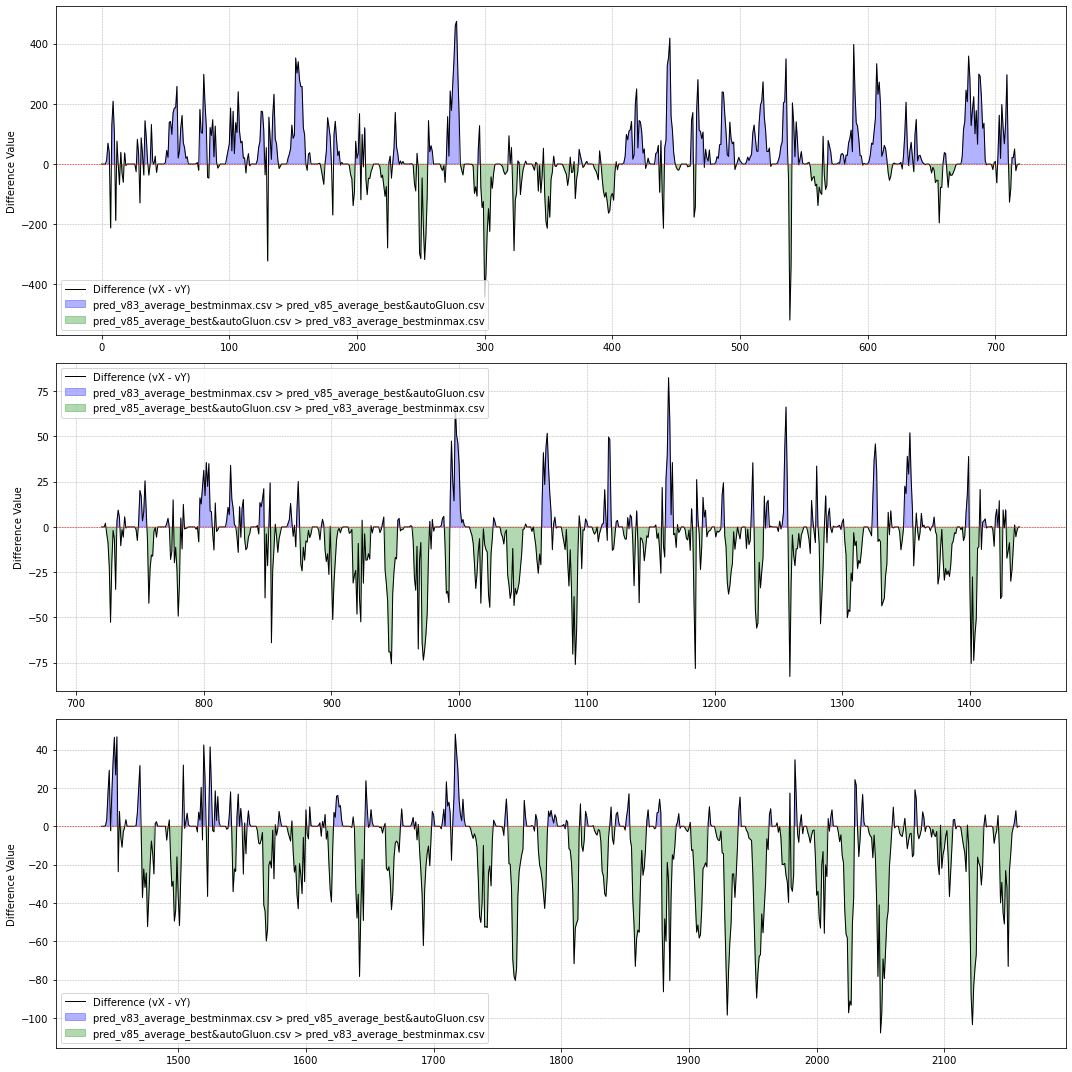

In [34]:
current_best = "pred_v83_average_bestminmax.csv"
eval = "pred_v85_average_best&autoGluon.csv"


df1 = pd.read_csv(current_best)
df2 = pd.read_csv(eval)

split_index = len(df1) // 3


df1_A = df1.iloc[:split_index]
df1_B = df1.iloc[split_index:2*split_index]
df1_C = df1.iloc[2*split_index:]

df2_A = df2.iloc[:split_index]
df2_B = df2.iloc[split_index:2*split_index]
df2_C = df2.iloc[2*split_index:]

def plot_difference(df1, df2):
    """Plot the difference between two dataframes' predictions."""
    diff = df1['prediction'] - df2['prediction']
    
    plt.plot(df1['id'], diff, label="Difference (vX - vY)", color="black", linewidth=1)
    
    # Highlight areas where Version X is greater than Version Y
    plt.fill_between(df1['id'], diff, where=(diff > 0), color='blue', alpha=0.3, label=f"{current_best} > {eval}")
    
    # Highlight areas where Version Y is greater than Version X
    plt.fill_between(df1['id'], diff, where=(diff < 0), color='green', alpha=0.3, label=f"{eval} > {current_best}")
    
    plt.axhline(0, color='red', linestyle="--", linewidth=0.5)
    plt.ylabel("Difference Value")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)


# Set up the plots
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

plt.sca(ax[0])
plot_difference(df1_A, df2_A)

plt.sca(ax[1])
plot_difference(df1_B, df2_B)

plt.sca(ax[2])
plot_difference(df1_C, df2_C)

plt.tight_layout()
plt.show()

## Feature Importance

We want to plot the feature importance of Catboost to verify that it weigh features that we agree with. We are not able to extract the feature importance of the model we get from AutoGluon as it is a stacked-ensambled model.

In [72]:
def plot_combined_feature_importances(models, model_names, n_features_to_plot=10):
    all_feature_importances = []
    
    # Assuming all models have the same features in the same order
    feature_names = models[0].feature_names_

    # Gather feature importances for each model
    for model in models:
        feature_importances = model.get_feature_importance(
            data=None,
            reference_data=None,
            prettified=False,
            thread_count=-1,
            verbose=False
        )
        all_feature_importances.append(feature_importances)

    # Create DataFrame
    feature_importances_df = pd.DataFrame(all_feature_importances, columns=feature_names, index=model_names).transpose()

    # Sort the DataFrame by the average importance across models and take top N for plotting
    feature_importances_df['Average'] = feature_importances_df.mean(axis=1)
    sorted_feature_importances_df = feature_importances_df.sort_values(by='Average', ascending=False).head(n_features_to_plot)

    # Drop the average as we no longer need it
    sorted_feature_importances_df = sorted_feature_importances_df.drop('Average', axis=1)
    
    # Plotting
    plt.figure(figsize=(12, 8))

    # Create the bar positions
    total_width = 0.8
    n_models = len(models)
    individual_width = total_width / n_models
    bar_positions = np.arange(n_features_to_plot)

    for i, model_name in enumerate(model_names):
        plt.barh(bar_positions + i * individual_width, sorted_feature_importances_df[model_name], height=individual_width, label=model_name)

    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top {n_features_to_plot} Feature Importances Across Models')
    plt.yticks(bar_positions + individual_width * (n_models - 1) / 2, sorted_feature_importances_df.index)
    plt.gca().invert_yaxis()  # To display the highest importance at the top
    plt.legend()
    plt.show()


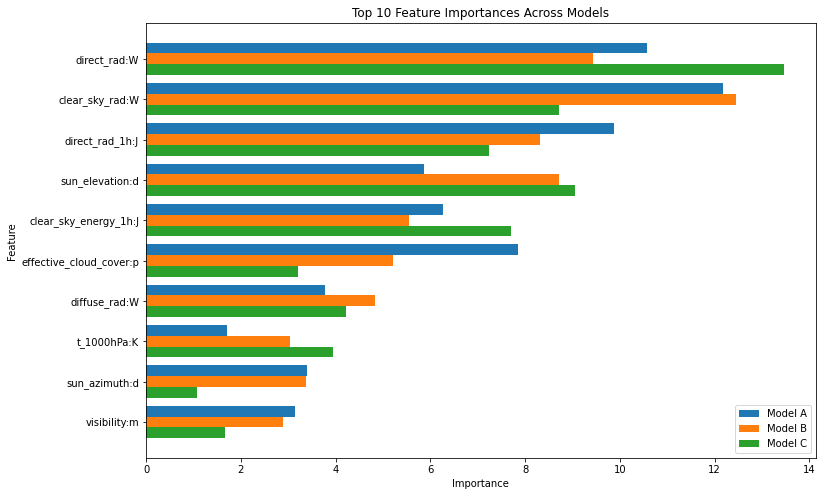

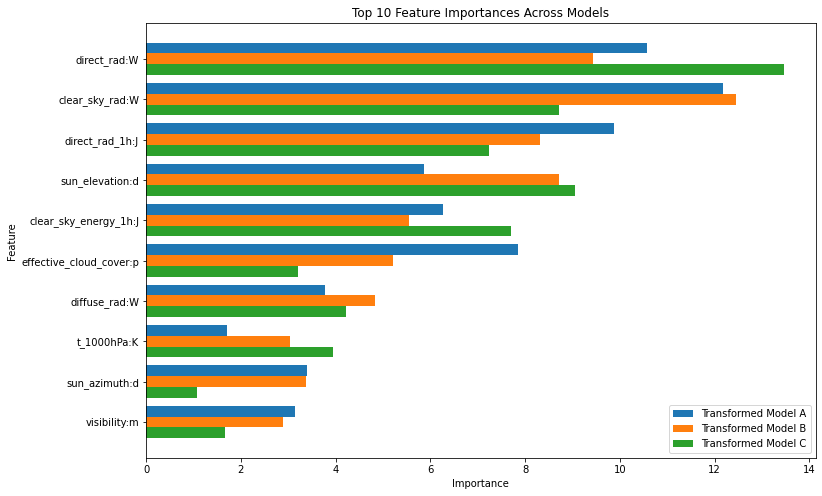

In [73]:
# Catboost
models = [model_a, model_b, model_c]
model_names = ['Model A', 'Model B', 'Model C']
plot_combined_feature_importances(models, model_names)

# Transformed Catboost
transformed_models = [transformed_model_a, transformed_model_b, transformed_model_c]
model_names = ['Transformed Model A', 'Transformed Model B', 'Transformed Model C']
plot_combined_feature_importances(models, model_names)

## Evaluation Metric

In [117]:
print(f"MAE for A: {model_a.get_best_score()['validation']['MAE']}")
print(f"MAE for B: {model_b.get_best_score()['validation']['MAE']}")
print(f"MAE for C: {model_c.get_best_score()['validation']['MAE']}")


transformed_mae_a = np.array(transformed_model_a.get_best_score()['validation']['MAE']).reshape(1, -1)
mae_a = scaler_a.inverse_transform(transformed_mae_a)

transformed_mae_b = np.array(transformed_model_b.get_best_score()['validation']['MAE']).reshape(1, -1)
mae_b = scaler_b.inverse_transform(transformed_mae_b)

transformed_mae_c = np.array(transformed_model_c.get_best_score()['validation']['MAE']).reshape(1, -1)
mae_c = scaler_c.inverse_transform(transformed_mae_c)

print(f"MAE for A: {mae_a[0][0]}")
print(f"MAE for B: {mae_b[0][0]}")
print(f"MAE for C: {mae_c[0][0]}")


Best validation score for A: 178.62505471122213
Best validation score for B: 24.93593961028518
Best validation score for C: 22.540552667445876
Best validation score for A: 175.5849170772673
Best validation score for B: 24.546849194514
Best validation score for C: 22.383531403207716
